In this notebook, I am going to implement GAN Network. 
GAN (Generative Adversial network) is a network which use to generate Fake or synthetic data which extremely looks like real one. 

GAN network presented by Ian GoodFellow. Paper link <a href = "https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf"> GAN PAPER</a>

I am using CIFAR 10 dataset which has 10 classes. Link to Dataset: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [1]:
import tensorflow as tf
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
path = os.path.join('..', 'Dataset\\CIFAR10')
os.listdir(path)

['batches.meta',
 'data_batch_1',
 'data_batch_2',
 'data_batch_3',
 'data_batch_4',
 'data_batch_5',
 'readme.html',
 'test_batch']

In [3]:
def unpickle(path):
    with open(path, 'rb') as f:
        data = pickle._Unpickler(f)
        data.encoding = 'latin1'
        d = data.load()
    return d

In [4]:
def one_hot_encode(data, categories):
    
    val = np.eye(categories)
    return val[data]

In [5]:
def data_load():
    data = [unpickle(path + '\\data_batch_{}'.format(i)) for i in range(1, 6)]
    images = np.vstack([i['data'] for i in data])
    label = np.hstack([i['labels'] for i in data])
    images = images.reshape(images.shape[0], 3, 32, 32).transpose(0, 2, 3, 1)
    
    return images, one_hot_encode(label, 10)

In [6]:
images, label = data_load()

In [2]:
def display_cifar(images, size):
     n = len(images)
     plt.figure()
     plt.gca().set_axis_off()
     im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)])
     for i in range(size)])
     plt.imshow(im)
     plt.show()

# display_cifar(images, 5)

Image Normalization

In [8]:
norm_images = images / 255

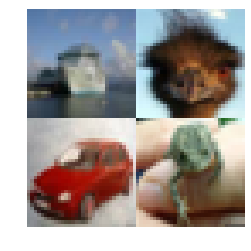

In [9]:
display_cifar(norm_images, 2)

So, now i am going to create two different convolutional neural networks:

- Generative Model: It is going to be a model which will generate fake images and optimize these images to be real.
- Discriminative Model: This model will be differentate between real and fake images


In generative model, i will send some Gaussian Noise, which will be converted into images and That noise will later sent to discriminative model for checking whether it is a real image or a fake image. 


In [13]:
## Defining the weight vectors. 
def W_Initializer(shape):
    W = tf.random.truncated_normal(shape)
    return tf.Variable(W)

def Bais_Initalizer(shape):
    b = tf.random.truncated_normal(shape)
    return tf.Variable(b)

def dense_layer(x, in_shape, out_shape):
    
    W = W_Initializer([in_shape, out_shape])
    b = Bais_Initalizer([out_shape])
    return tf.nn.relu(tf.matmul(x, W) + b)

def dense_layer_sigmoid(x, in_shape, out_shape):
    W = W_Initializer([in_shape, out_shape])
    b = Bais_Initalizer([out_shape])
    return tf.nn.sigmoid(tf.matmul(x, W) + b)

def batch_norm(x):
    return tf.layers.batch_normalization(x)

So, i am considering generative model to be a 4 layered fully connected neural network. 

In [14]:
x_gen = tf.placeholder(tf.float32, shape = (None, 3072), name = 'input_gen')
y_gen = tf.placeholder(tf.float32, shape = (None, 1), name = 'Actual_Output_Generator')

In [16]:
n_hidden = 3072

with tf.name_scope('Generative_Model') as s:
    dense1_gen = dense_layer(x_gen, n_hidden, n_hidden)
    norm1_gen = batch_norm(dense1_gen)
    dense2_gen = dense_layer(norm1_gen, n_hidden, n_hidden)
    norm2_gen = batch_norm(dense2_gen)
    dense3_gen = dense_layer(norm2_gen, n_hidden, n_hidden)
    norm3_gen = batch_norm(dense3_gen)
    op_layer_gen = dense_layer_sigmoid(norm3_gen, n_hidden, 1)

Discriminative neural network will be a 4 layered densely connected network

In [19]:
x_dis = tf.placeholder(tf.float32, shape = (None, n_hidden), name = 'input_dis')
y_dis = tf.placeholder(tf.float32, shape = (None, 1), name = 'Actual_Output_Discriminator')
with tf.name_scope('Discriminative_Model') as s:
    dense1_dis = dense_layer(x_dis, n_hidden, n_hidden)
    norm1_dis = batch_norm(dense1_dis)
    dense2_dis = dense_layer(norm1_dis, n_hidden, n_hidden)
    dense3_dis = dense_layer(dense2_dis, n_hidden, n_hidden)
    op_layer_dis = dense_layer_sigmoid(dense3_dis, n_hidden, 1)

In [20]:
with tf.name_scope('Optimizers') as s:
    gen_optimizer = tf.train.AdamOptimizer(0.01)
    dis_optimizer = tf.train.AdamOptimizer(0.01)
    

In [21]:
g_var = [var for var in tf.trainable_variables() if 'Generative_Model' in var.name]
d_var = [var for var in tf.trainable_variables() if 'Discriminative_Model' in var.name]

In [22]:
with tf.name_scope('Loss') as s:
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = op_layer_gen, labels = y_gen))
    dis_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = op_layer_dis, labels = y_dis))
    g_loss = gen_optimizer.minimize(gen_loss)
    d_loss = dis_optimizer.minimize(dis_loss)

In [23]:
dis_loss

<tf.Tensor 'Loss/Mean_1:0' shape=() dtype=float32>

In [24]:
NUM_STEPS = 1000
Generative_loss_dir = []
Discriminative_loss_dir = []
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for i in range(NUM_STEPS):
        
        ## This data for Genrative Model
        fake_image = np.random.normal(size = (128, 3072))
        gen_label = np.ones((128, 1)) ## Generative model will consider all the images are real.
        
#         ## This data for Discriminative Model
        real_index = np.random.choice(np.arange(images.shape[0]), 128) 
        real_img = images[real_index]
        real_label = np.ones((128, 1))
        fake_label = np.zeros((128, 1))
        
        ## For Discriminative Model will take real and fake images but the 
        ## label for real image will be 1 and label for fake images will be 0
        
        ## Generative model will take fake images 
        geneative_loss, g_step, gen_fake_images= sess.run([gen_loss, g_loss, dense3_gen], feed_dict = {x_gen: fake_image, y_gen: gen_label})
        Generative_loss_dir.append(geneative_loss)
        print ('Iteration: ', i, ' Generative Loss: ', geneative_loss, end = '  ')
        ## Discriminative model will take real images + fake images
        real_img = np.reshape(real_img, (-1, 32 * 32 * 3)) ## Flatten the image 
        dis_input = np.concatenate([real_img, gen_fake_images], axis = 0)
        dis_label = np.concatenate([real_label, fake_label], axis = 0)
        
        discriminative_loss, d_step = sess.run([dis_loss, d_loss], feed_dict = {x_dis: dis_input, y_dis: dis_label})
        Discriminative_loss_dir.append(discriminative_loss)
        print ('Discriminative Loss: ', discriminative_loss)
        
#     tf.summary.FileWriter('./GAN_MODEL', sess.graph)

Iteration:  0  Generative Loss:  0.348876  Discriminative Loss:  0.69166327
Iteration:  1  Generative Loss:  0.34294027  Discriminative Loss:  0.6931472
Iteration:  2  Generative Loss:  0.35184383  Discriminative Loss:  0.69166327
Iteration:  3  Generative Loss:  0.35481167  Discriminative Loss:  0.69166327
Iteration:  4  Generative Loss:  0.34294027  Discriminative Loss:  0.6931472
Iteration:  5  Generative Loss:  0.3310688  Discriminative Loss:  0.69166327
Iteration:  6  Generative Loss:  0.3459081  Discriminative Loss:  0.6931472
Iteration:  7  Generative Loss:  0.33403668  Discriminative Loss:  0.6931472
Iteration:  8  Generative Loss:  0.3399724  Discriminative Loss:  0.69166327
Iteration:  9  Generative Loss:  0.34294024  Discriminative Loss:  0.6931472
Iteration:  10  Generative Loss:  0.3607474  Discriminative Loss:  0.6955695
Iteration:  11  Generative Loss:  0.33997238  Discriminative Loss:  0.6955695
Iteration:  12  Generative Loss:  0.34887597  Discriminative Loss:  0.69314

Iteration:  105  Generative Loss:  0.32810095  Discriminative Loss:  0.69166327
Iteration:  106  Generative Loss:  0.33403668  Discriminative Loss:  0.69166327
Iteration:  107  Generative Loss:  0.3459081  Discriminative Loss:  0.69166327
Iteration:  108  Generative Loss:  0.34294027  Discriminative Loss:  0.6931472
Iteration:  109  Generative Loss:  0.3340367  Discriminative Loss:  0.69166327
Iteration:  110  Generative Loss:  0.3310688  Discriminative Loss:  0.6955695
Iteration:  111  Generative Loss:  0.33997238  Discriminative Loss:  0.69017935
Iteration:  112  Generative Loss:  0.33700454  Discriminative Loss:  0.6940856
Iteration:  113  Generative Loss:  0.34294024  Discriminative Loss:  0.6931472
Iteration:  114  Generative Loss:  0.34294027  Discriminative Loss:  0.6931472
Iteration:  115  Generative Loss:  0.34294027  Discriminative Loss:  0.69017935
Iteration:  116  Generative Loss:  0.3459081  Discriminative Loss:  0.6940856
Iteration:  117  Generative Loss:  0.32513312  Dis

Iteration:  208  Generative Loss:  0.33403668  Discriminative Loss:  0.6926016
Iteration:  209  Generative Loss:  0.33700454  Discriminative Loss:  0.6931472
Iteration:  210  Generative Loss:  0.3607474  Discriminative Loss:  0.6940856
Iteration:  211  Generative Loss:  0.34294027  Discriminative Loss:  0.68721145
Iteration:  212  Generative Loss:  0.3459081  Discriminative Loss:  0.69166327
Iteration:  213  Generative Loss:  0.33997238  Discriminative Loss:  0.6926016
Iteration:  214  Generative Loss:  0.33403668  Discriminative Loss:  0.69166327
Iteration:  215  Generative Loss:  0.34887597  Discriminative Loss:  0.69166327
Iteration:  216  Generative Loss:  0.33997238  Discriminative Loss:  0.6940856
Iteration:  217  Generative Loss:  0.33106884  Discriminative Loss:  0.6931472
Iteration:  218  Generative Loss:  0.3399724  Discriminative Loss:  0.6955695
Iteration:  219  Generative Loss:  0.3459081  Discriminative Loss:  0.69166327
Iteration:  220  Generative Loss:  0.33997238  Disc

Iteration:  312  Generative Loss:  0.33403668  Discriminative Loss:  0.69166327
Iteration:  313  Generative Loss:  0.32810098  Discriminative Loss:  0.6931472
Iteration:  314  Generative Loss:  0.3310688  Discriminative Loss:  0.6940856
Iteration:  315  Generative Loss:  0.32513312  Discriminative Loss:  0.6931472
Iteration:  316  Generative Loss:  0.32216525  Discriminative Loss:  0.6931472
Iteration:  317  Generative Loss:  0.3310688  Discriminative Loss:  0.69166327
Iteration:  318  Generative Loss:  0.3399724  Discriminative Loss:  0.69017935
Iteration:  319  Generative Loss:  0.3459081  Discriminative Loss:  0.69017935
Iteration:  320  Generative Loss:  0.33997238  Discriminative Loss:  0.69166327
Iteration:  321  Generative Loss:  0.33997238  Discriminative Loss:  0.69166327
Iteration:  322  Generative Loss:  0.3310688  Discriminative Loss:  0.6886954
Iteration:  323  Generative Loss:  0.34294024  Discriminative Loss:  0.6931472
Iteration:  324  Generative Loss:  0.33997238  Disc

Iteration:  415  Generative Loss:  0.33700454  Discriminative Loss:  0.69017935
Iteration:  416  Generative Loss:  0.34294027  Discriminative Loss:  0.6926017
Iteration:  417  Generative Loss:  0.33403668  Discriminative Loss:  0.6931472
Iteration:  418  Generative Loss:  0.33403668  Discriminative Loss:  0.6931472
Iteration:  419  Generative Loss:  0.34294027  Discriminative Loss:  0.6931472
Iteration:  420  Generative Loss:  0.34887597  Discriminative Loss:  0.6931472
Iteration:  421  Generative Loss:  0.33997238  Discriminative Loss:  0.69166327
Iteration:  422  Generative Loss:  0.33700454  Discriminative Loss:  0.69166327
Iteration:  423  Generative Loss:  0.3459081  Discriminative Loss:  0.69017935
Iteration:  424  Generative Loss:  0.33700454  Discriminative Loss:  0.69166327
Iteration:  425  Generative Loss:  0.3459081  Discriminative Loss:  0.6931472
Iteration:  426  Generative Loss:  0.3399724  Discriminative Loss:  0.69166327
Iteration:  427  Generative Loss:  0.33700454  Di

Iteration:  519  Generative Loss:  0.3607474  Discriminative Loss:  0.69166327
Iteration:  520  Generative Loss:  0.3399724  Discriminative Loss:  0.6940856
Iteration:  521  Generative Loss:  0.34294024  Discriminative Loss:  0.6955695
Iteration:  522  Generative Loss:  0.33700454  Discriminative Loss:  0.69166327
Iteration:  523  Generative Loss:  0.34294024  Discriminative Loss:  0.69166327
Iteration:  524  Generative Loss:  0.3310688  Discriminative Loss:  0.69166327
Iteration:  525  Generative Loss:  0.35184383  Discriminative Loss:  0.6931472
Iteration:  526  Generative Loss:  0.35184383  Discriminative Loss:  0.6926017
Iteration:  527  Generative Loss:  0.32810098  Discriminative Loss:  0.69017935
Iteration:  528  Generative Loss:  0.3399724  Discriminative Loss:  0.6931472
Iteration:  529  Generative Loss:  0.3459081  Discriminative Loss:  0.6955695
Iteration:  530  Generative Loss:  0.3459081  Discriminative Loss:  0.695024
Iteration:  531  Generative Loss:  0.32810098  Discrim

Iteration:  623  Generative Loss:  0.33700454  Discriminative Loss:  0.6955695
Iteration:  624  Generative Loss:  0.3459081  Discriminative Loss:  0.69166327
Iteration:  625  Generative Loss:  0.32810098  Discriminative Loss:  0.6931472
Iteration:  626  Generative Loss:  0.33403668  Discriminative Loss:  0.6955695
Iteration:  627  Generative Loss:  0.34294027  Discriminative Loss:  0.69017935
Iteration:  628  Generative Loss:  0.3310688  Discriminative Loss:  0.6931472
Iteration:  629  Generative Loss:  0.3459081  Discriminative Loss:  0.6926017
Iteration:  630  Generative Loss:  0.3399724  Discriminative Loss:  0.69166327
Iteration:  631  Generative Loss:  0.33700454  Discriminative Loss:  0.6955695
Iteration:  632  Generative Loss:  0.33106884  Discriminative Loss:  0.6931472
Iteration:  633  Generative Loss:  0.3399724  Discriminative Loss:  0.69017935
Iteration:  634  Generative Loss:  0.35184383  Discriminative Loss:  0.69166327
Iteration:  635  Generative Loss:  0.33403668  Discr

Iteration:  727  Generative Loss:  0.47649372  Discriminative Loss:  0.6931472
Iteration:  728  Generative Loss:  0.48242947  Discriminative Loss:  0.69166327
Iteration:  729  Generative Loss:  0.45275092  Discriminative Loss:  0.6931472
Iteration:  730  Generative Loss:  0.47055805  Discriminative Loss:  0.69166327
Iteration:  731  Generative Loss:  0.50023663  Discriminative Loss:  0.69166327
Iteration:  732  Generative Loss:  0.46462232  Discriminative Loss:  0.6931472
Iteration:  733  Generative Loss:  0.48836517  Discriminative Loss:  0.6931472
Iteration:  734  Generative Loss:  0.5002366  Discriminative Loss:  0.69017935
Iteration:  735  Generative Loss:  0.45868662  Discriminative Loss:  0.69166327
Iteration:  736  Generative Loss:  0.45868665  Discriminative Loss:  0.69166327
Iteration:  737  Generative Loss:  0.47352588  Discriminative Loss:  0.6931472
Iteration:  738  Generative Loss:  0.47649378  Discriminative Loss:  0.69017935
Iteration:  739  Generative Loss:  0.48242947 

Iteration:  831  Generative Loss:  0.4853973  Discriminative Loss:  0.6931472
Iteration:  832  Generative Loss:  0.4794616  Discriminative Loss:  0.68721145
Iteration:  833  Generative Loss:  0.4853973  Discriminative Loss:  0.69166327
Iteration:  834  Generative Loss:  0.46462235  Discriminative Loss:  0.6886954
Iteration:  835  Generative Loss:  0.47649375  Discriminative Loss:  0.69166327
Iteration:  836  Generative Loss:  0.45868662  Discriminative Loss:  0.69166327
Iteration:  837  Generative Loss:  0.45275092  Discriminative Loss:  0.69166327
Iteration:  838  Generative Loss:  0.4943009  Discriminative Loss:  0.69166327
Iteration:  839  Generative Loss:  0.47352588  Discriminative Loss:  0.69166327
Iteration:  840  Generative Loss:  0.46165445  Discriminative Loss:  0.69166327
Iteration:  841  Generative Loss:  0.4527509  Discriminative Loss:  0.69166327
Iteration:  842  Generative Loss:  0.47055805  Discriminative Loss:  0.69166327
Iteration:  843  Generative Loss:  0.47649375  

Iteration:  935  Generative Loss:  0.49726874  Discriminative Loss:  0.6931472
Iteration:  936  Generative Loss:  0.4735259  Discriminative Loss:  0.69166327
Iteration:  937  Generative Loss:  0.48242944  Discriminative Loss:  0.6931472
Iteration:  938  Generative Loss:  0.49726877  Discriminative Loss:  0.69166327
Iteration:  939  Generative Loss:  0.4794616  Discriminative Loss:  0.69166327
Iteration:  940  Generative Loss:  0.4794616  Discriminative Loss:  0.6931472
Iteration:  941  Generative Loss:  0.46462232  Discriminative Loss:  0.6857275
Iteration:  942  Generative Loss:  0.48242947  Discriminative Loss:  0.6931472
Iteration:  943  Generative Loss:  0.50023663  Discriminative Loss:  0.6931472
Iteration:  944  Generative Loss:  0.4468152  Discriminative Loss:  0.69166327
Iteration:  945  Generative Loss:  0.47055805  Discriminative Loss:  0.6931472
Iteration:  946  Generative Loss:  0.4735259  Discriminative Loss:  0.69166327
Iteration:  947  Generative Loss:  0.4943009  Discri

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


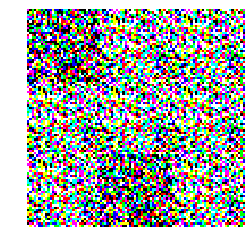

In [29]:
display_cifar(gen_fake_images.reshape(-1, 32, 32, 3), 3)

Text(0, 0.5, 'Loss ==>')

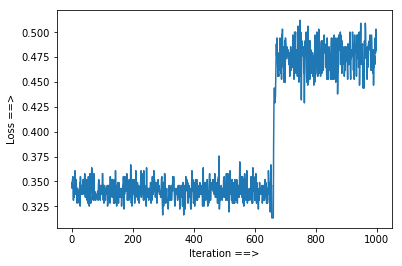

In [26]:
plt.plot(Generative_loss_dir)
plt.xlabel('Iteration ==>')
plt.ylabel('Loss ==>')

Text(0, 0.5, 'Loss ==>')

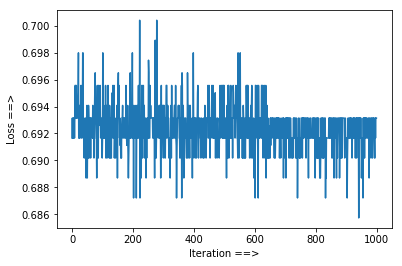

In [27]:
plt.plot(Discriminative_loss_dir)
plt.xlabel('Iteration ==>')
plt.ylabel('Loss ==>')

Implementing GAN on MNIST Number dataset.

In [12]:
from tensorflow.examples.tutorials import mnist

In [13]:
data = mnist.input_data.read_data_sets('/tmp/data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data\train-labels-idx1-ubyte.gz
Extracting /tmp/data\t10k-images-idx3-ubyte.gz
Extracting /tmp/data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [16]:
train_img = data.train.images
train_label = data.train.labels

In [17]:
train_img.shape

(55000, 784)

In [3]:
## Defining the weight vectors. 
def W_Initializer(shape):
    W = tf.random.normal(shape)
    return tf.Variable(W)

def Bais_Initalizer(shape):
    b = tf.random.normal(shape)
    return tf.Variable(b)

def dense_layer(x, in_shape, out_shape):
    
    W = W_Initializer([in_shape, out_shape])
    b = Bais_Initalizer([out_shape])
    return tf.nn.relu(tf.matmul(x, W))

def dense_layer_sigmoid(x, in_shape, out_shape):
    W = W_Initializer([in_shape, out_shape])
    b = Bais_Initalizer([out_shape])
    return tf.nn.sigmoid(tf.matmul(x, W))

def batch_norm(x):
    return tf.layers.batch_normalization(x)

In [4]:
x_gen = tf.placeholder(tf.float32, shape = (None, 784), name = 'input_gen')
y_gen = tf.placeholder(tf.float32, shape = (None, 1), name = 'Actual_Output_Generator')

In [25]:
n_hidden = 784

with tf.name_scope('Generative_Model') as s:
    dense1_gen = dense_layer(x_gen, n_hidden, n_hidden)
    norm1_gen = batch_norm(dense1_gen)
    dense2_gen = dense_layer(norm1_gen, n_hidden, n_hidden)
    dense3_gen = dense_layer(dense2_gen, n_hidden, n_hidden)
    op_layer_gen = dense_layer_sigmoid(dense3_gen, n_hidden, 1)

In [26]:
x_dis = tf.placeholder(tf.float32, shape = (None, 784), name = 'input_dis')
y_dis = tf.placeholder(tf.float32, shape = (None, 1), name = 'Actual_Output_Discriminator')

with tf.name_scope('Discriminative_Model') as s:
    dense1_dis = dense_layer(x_dis, n_hidden, n_hidden)
    norm1_dis = batch_norm(dense1_dis)
    dense2_dis = dense_layer(norm1_dis, n_hidden, n_hidden)
    dense3_dis = dense_layer(dense2_dis, n_hidden, n_hidden)
    op_layer_dis = dense_layer_sigmoid(dense3_dis, n_hidden, 1)

In [27]:
with tf.name_scope('Optimizers') as s:
    gen_optimizer = tf.train.AdamOptimizer(0.01)
    dis_optimizer = tf.train.AdamOptimizer(0.01)

In [28]:
g_vars = [var for var in tf.trainable_variables() if 'Generative' in var.name]
d_vars = [var for var in tf.trainable_variables() if 'Dis' in var.name]
g_vars

[<tf.Variable 'Generative_Model/Variable:0' shape=(784, 784) dtype=float32_ref>,
 <tf.Variable 'Generative_Model/Variable_1:0' shape=(784,) dtype=float32_ref>,
 <tf.Variable 'Generative_Model/Variable_2:0' shape=(784, 784) dtype=float32_ref>,
 <tf.Variable 'Generative_Model/Variable_3:0' shape=(784,) dtype=float32_ref>,
 <tf.Variable 'Generative_Model/Variable_4:0' shape=(784, 784) dtype=float32_ref>,
 <tf.Variable 'Generative_Model/Variable_5:0' shape=(784,) dtype=float32_ref>,
 <tf.Variable 'Generative_Model/Variable_6:0' shape=(784, 1) dtype=float32_ref>,
 <tf.Variable 'Generative_Model/Variable_7:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'Generative_Model_1/Variable:0' shape=(784, 784) dtype=float32_ref>,
 <tf.Variable 'Generative_Model_1/Variable_1:0' shape=(784,) dtype=float32_ref>,
 <tf.Variable 'Generative_Model_1/Variable_2:0' shape=(784, 784) dtype=float32_ref>,
 <tf.Variable 'Generative_Model_1/Variable_3:0' shape=(784,) dtype=float32_ref>,
 <tf.Variable 'Generative_Mo

In [29]:
d_vars

[<tf.Variable 'Discriminative_Model/Variable:0' shape=(784, 784) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model/Variable_1:0' shape=(784,) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model/Variable_2:0' shape=(784, 784) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model/Variable_3:0' shape=(784,) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model/Variable_4:0' shape=(784, 784) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model/Variable_5:0' shape=(784,) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model/Variable_6:0' shape=(784, 1) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model/Variable_7:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model_1/Variable:0' shape=(784, 784) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model_1/Variable_1:0' shape=(784,) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model_1/Variable_2:0' shape=(784, 784) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model_1/Variable_3:0' shape=(784,) 

In [30]:
with tf.name_scope('Loss') as s:
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = op_layer_gen, labels = y_gen))
    dis_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = op_layer_dis, labels = y_dis))
    g_loss = gen_optimizer.minimize(gen_loss, var_list= g_vars)
    d_loss = dis_optimizer.minimize(dis_loss, var_list= d_vars)

In [ ]:
NUM_STEPS = 100
batch_size = 1024
Gen_loss_dir = []
Dis_loss_dir = []
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for i in range(NUM_STEPS):
        
        ## This data for Genrative Model
        fake_image = np.random.normal(size = (batch_size, 784))
        gen_label = np.ones((batch_size, 1)) ## Generative model will consider all the images are real.
        
        ## This data for Discriminative Model
        real_index = np.random.choice(np.arange(train_img.shape[0]), batch_size) 
        real_img = train_img[real_index]
        real_label = np.ones((batch_size, 1))
        fake_label = np.zeros((batch_size, 1))
        
        ## For Discriminative Model will take real and fake images but the 
        ## label for real image will be 1 and label for fake images will be 0
        
        ## Generative model will take fake images 
        g_step, gen_fake_images, geneative_loss = sess.run([g_loss, dense3_gen, gen_loss], feed_dict = {x_gen: fake_image, y_gen: gen_label})
#         print ('Generative Model')
        print ('Iteration: ', i)
        print ('Generative Loss: ', geneative_loss, end = '  ')
        Gen_loss_dir.append(geneative_loss)
        ## Discriminative model will take real images + fake images
        dis_input = np.concatenate([real_img, gen_fake_images], axis = 0)
        dis_label = np.concatenate([real_label, fake_label], axis = 0)
        
        discriminative_loss, d_step = sess.run([dis_loss, d_loss], feed_dict = {x_dis: dis_input, y_dis: dis_label})
        Dis_loss_dir.append(discriminative_loss)
        print (' Discriminative Loss: ', discriminative_loss)
        
#     tf.summary.FileWriter('./GAN_MODEL', sess.graph)

Iteration:  0
Generative Loss:  0.4731549   Discriminative Loss:  0.72183764
Iteration:  1
Generative Loss:  0.49059108   Discriminative Loss:  0.7179123
Iteration:  2
Generative Loss:  0.47389665   Discriminative Loss:  0.71782506
Iteration:  3
Generative Loss:  0.32624605   Discriminative Loss:  0.7151559
Iteration:  4
Generative Loss:  0.31326172   Discriminative Loss:  0.8129591
Iteration:  5
Generative Loss:  0.31326172   Discriminative Loss:  0.81326187
Iteration:  6
Generative Loss:  0.31326172   Discriminative Loss:  0.81326187
Iteration:  7
Generative Loss:  0.31326172   Discriminative Loss:  0.81326187
Iteration:  8
Generative Loss:  0.31326172   Discriminative Loss:  0.81326187
Iteration:  9
Generative Loss:  0.31326172   Discriminative Loss:  0.81326187
Iteration:  10
Generative Loss:  0.31326172   Discriminative Loss:  0.81326187
Iteration:  11
Generative Loss:  0.31326172   Discriminative Loss:  0.81326187
Iteration:  12
Generative Loss:  0.31326172   Discriminative Loss:

Text(0, 0.5, 'Loss ==>')

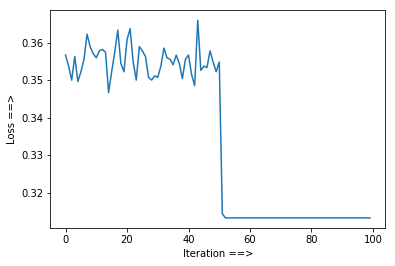

In [19]:
plt.plot(Gen_loss_dir)
plt.xlabel('Iteration ==>')
plt.ylabel('Loss ==>')

Text(0, 0.5, 'Loss ==>')

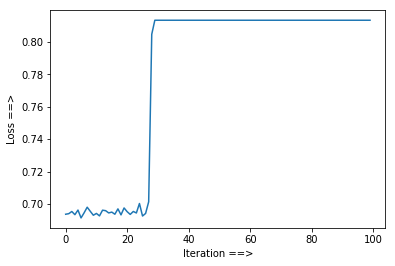

In [20]:
plt.plot(Dis_loss_dir)
plt.xlabel('Iteration ==>')
plt.ylabel('Loss ==>')

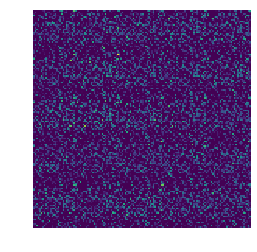

In [21]:
display_cifar(gen_fake_images.reshape(-1, 28, 28), 5)

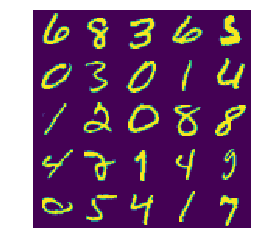

In [22]:
display_cifar(train_img.reshape(-1, 28, 28), 5)